In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Dogs VS Cats Classification Homework**

Dataset from Kaggle 
25,000 .jpg files of dogs and cats. The photos are labeled by their filename, with the word “dog” or “cat“. 

**Import Library**

In [3]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import cv2
import random
import shutil
import numpy as np 
import pandas as pd 
import seaborn as sns
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential,Model
from keras.layers import Conv2D,Flatten,MaxPooling2D,Dense,GlobalAveragePooling2D,Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

**Prepare Training Data**

 
 1 ---> dog  
 0 ---> cat



In [51]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/dogs-vs-cats/"+'train'+".zip","r") as z:
    z.extractall(".")

In [6]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/dogs-vs-cats/"+'test1'+".zip","r") as z:
    z.extractall(".")

In [7]:
Y = []
path = "./train"
filenames = os.listdir(path)
for img in os.listdir(path):
    val = img.split(".")[0]
    if val == "dog":
        Y.append('1')
    else:
        Y.append('0')

df = pd.DataFrame({
    'filename' : filenames,
    'category' : Y
})

In [8]:
df.tail()

,filename,category
24995,dog.2671.jpg,1
24996,dog.6140.jpg,1
24997,cat.7711.jpg,0
24998,cat.5670.jpg,0
24999,dog.1506.jpg,1


**Plot Random Dataset Image**

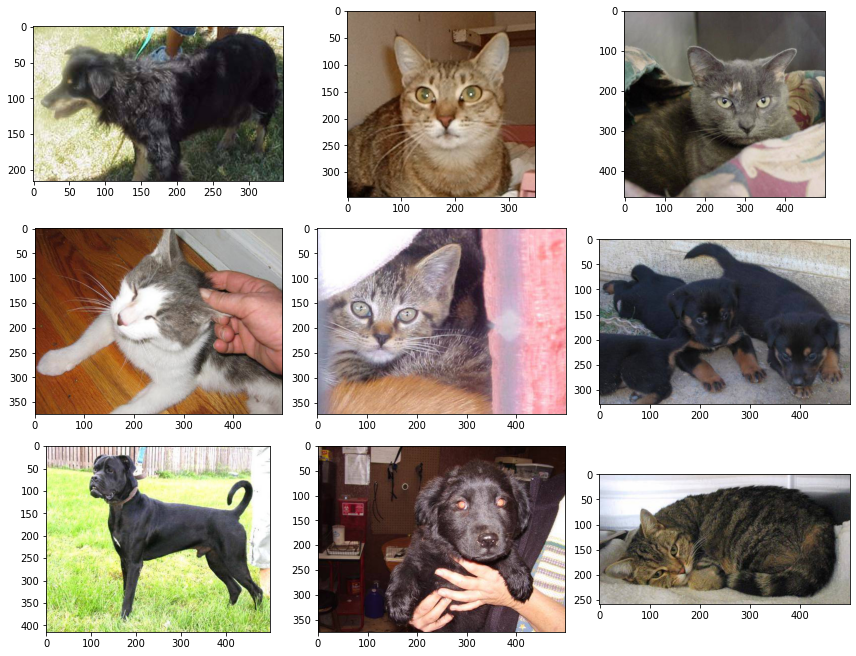

In [9]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(4, 3, i+1)
    sample = random.choice(filenames)
    filename = path+'/'+sample
    image = imread(filename)
    plt.imshow(image)
plt.tight_layout()
plt.show()

**Train Test Split**

 20% of dataset --> validation
 the rest --> training purpose.
 different set of images (new unseen images) --> test the model

In [10]:
train_df,val_df = train_test_split(df,test_size=0.2,random_state = 42)
train_valid_df, test_df = train_test_split(df, test_size = 0.04)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


**Total Count**

 number of dogs = cats in both  training and validation dataset ---> no problem in training the model

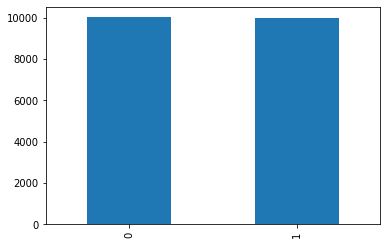

In [11]:
train_df['category'].value_counts().plot.bar()

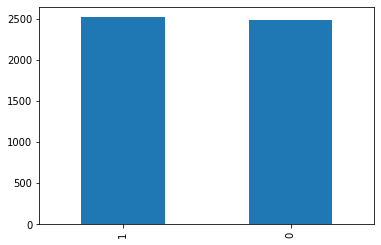

In [12]:
val_df['category'].value_counts().plot.bar()

**Constants**

In [13]:
batch_size = 32
epochs = 50
train_size = train_df.shape[0]
val_size = val_df.shape[0]
img_hieght = 128
img_width = 128
img_channels = 3

**Training Generator**

In [14]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range = 0.1,
    fill_mode = 'reflect',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./train",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 20000 validated image filenames belonging to 2 classes.


In [15]:
example_df = train_df.sample(n=1)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./train",
    x_col='filename',
    y_col='category',
    target_size=(img_hieght,img_width),
    class_mode='raw'
)

Found 1 validated image filenames.


 9 different variations of a single image created by data augmentation techniques.
Some properties (horizontal flip, zoom ) makes difference as shown below 

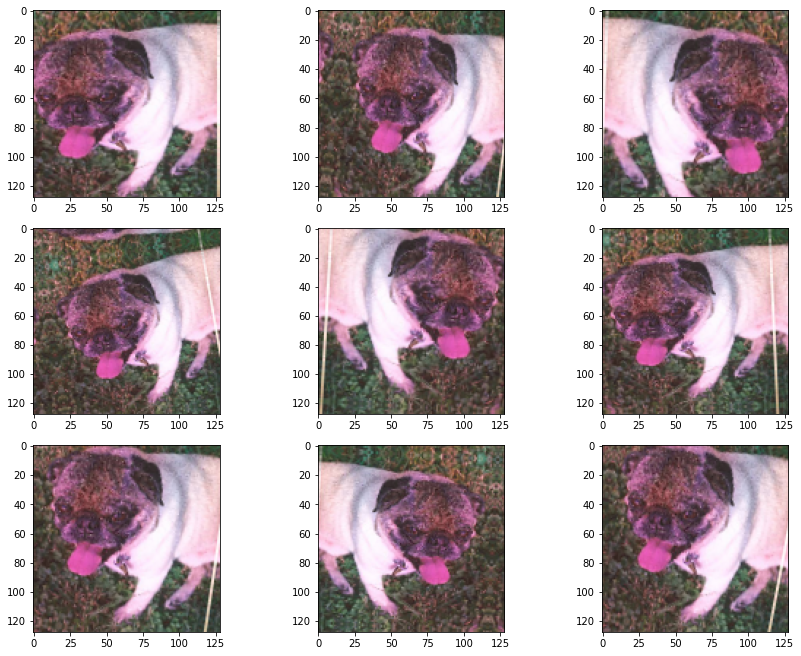

In [16]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(4, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

**Validation Generator**

We will not apply any data augmentation technique like horizontal flip, zoom etc on validation set because we are not going to use this for training purpose.

In [17]:
val_datagen = ImageDataGenerator(
    rescale = 1./255,
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    "./train",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 5000 validated image filenames belonging to 2 classes.


**The CNN model**

In [18]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape = (img_hieght,img_width,img_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)
callbacks = [learning_rate_reduction]

model.summary() gives the description of the architecture of our model.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [21]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

**Fit Model**

In [22]:
history=model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data =  val_generator,
    steps_per_epoch = train_size//batch_size,
    validation_steps = val_size//batch_size,
    callbacks = callbacks
)

<ipython-input-22-a111fe4176c8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(


Epoch 1/50
625/625 [==============================] - 144s 216ms/step - loss: 0.6748 - accuracy: 0.6493 - val_loss: 0.5644 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 132s 211ms/step - loss: 0.5470 - accuracy: 0.7212 - val_loss: 0.4583 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 133s 213ms/step - loss: 0.4938 - accuracy: 0.7571 - val_loss: 0.4461 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 140s 224ms/step - loss: 0.4463 - accuracy: 0.7925 - val_loss: 0.4257 - val_accuracy: 0.8005 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 133s 212ms/step - loss: 0.4122 - accuracy: 0.8116 - val_loss: 0.3672 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 132s 211ms/step - loss: 0.3819 - accuracy: 0.8274 - val_loss: 0.3817 - val_accuracy: 0.8251 - lr: 0.0010
Epoch 7/50
625/625 [==========================

**Saving the Model**

In [23]:
model.save("model.h5")

In [24]:
 #model = load_model("/kaggle/input/modele/model(1).h5")

In [25]:
#history=model

**Virtualize training**

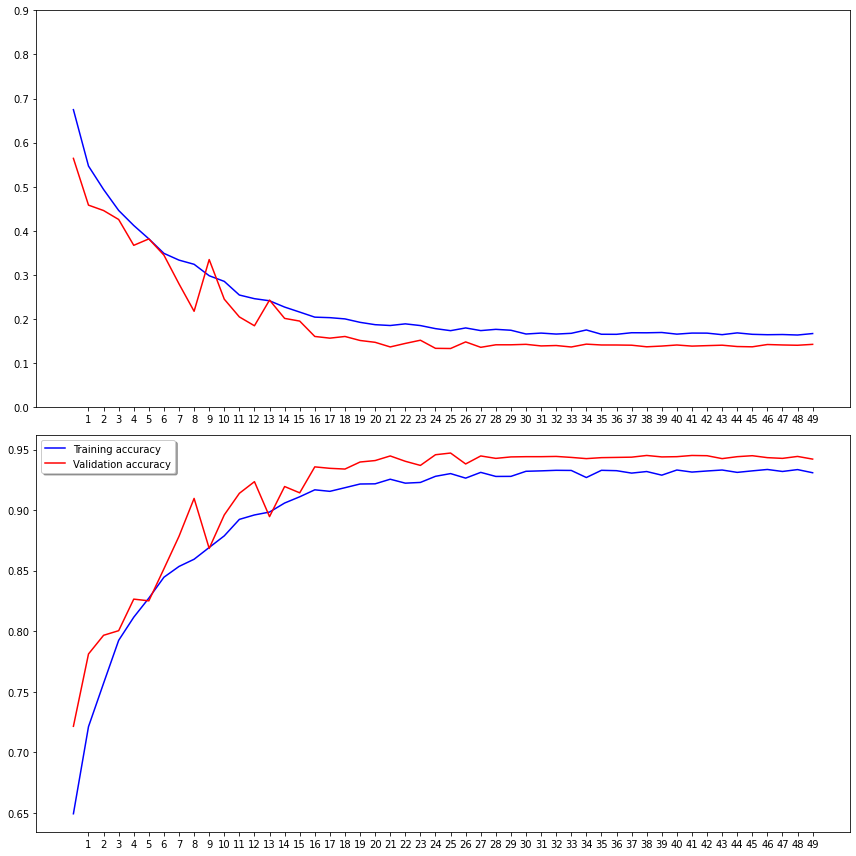

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

**Validation Accuracy**

In [27]:
score = model.evaluate_generator(val_generator)
print(score[1]*100)

<ipython-input-27-da3b8b0fe026>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(val_generator)


94.22000050544739


**Training Accuracy**

Here we are going to calculate model's accuracy on training set itself.

In [28]:
score = model.evaluate_generator(train_generator)
print(score[1]*100)

<ipython-input-28-27a0e55705ca>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(train_generator)


94.92499828338623


**Confusion Matrix**

In [29]:
conf_datagen = ImageDataGenerator(
    rescale = 1./255,
)

conf_generator = conf_datagen.flow_from_dataframe(
    val_df,
    "./train",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'binary'
)

Found 5000 validated image filenames belonging to 2 classes.


In [30]:
y_predict = model.predict_generator(conf_generator)

<ipython-input-30-7545b72add6a>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_predict = model.predict_generator(conf_generator)


In [31]:
y_predict = np.where(y_predict > 0.5, 1, 0)

In [32]:
p = conf_generator.classes
q = y_predict
p = np.array(p)
q = q.flatten()

[[2414   70]
 [ 219 2297]]


[Text(0, 0.5, 'cats'), Text(0, 1.5, 'dogs')]

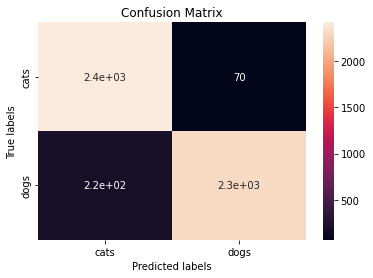

In [33]:
cfm = confusion_matrix(p, q)
print(cfm)
ax= plt.subplot()
sns.heatmap(cfm, annot=True, ax = ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['cats', 'dogs'])
ax.yaxis.set_ticklabels(['cats', 'dogs'])

In [34]:
print(classification_report(p,q))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2484
           1       0.97      0.91      0.94      2516

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



**Prediction**

1/1 [==============================] - 0s 220ms/step
According to our model's prediction below image is of a Cat


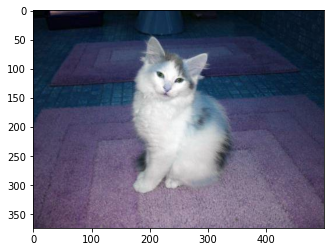

In [35]:
path = "/content/drive/MyDrive/dogs-vs-cats/test1/test1/10.jpg"
img = cv2.imread(path)
plt.imshow(img)
img = cv2.resize(img,(128,128))
img = np.reshape(img,[1,128,128,3])
img = np.divide(img,255)
result = model.predict(img)
if result[0] >= 0.5:
    print("According to our model's prediction below image is of a Dog")
else:
    print("According to our model's prediction below image is of a Cat")

In [36]:
shutil.rmtree("./train")

**Resnet**

In [37]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping,LearningRateScheduler


from keras import backend as K
K.clear_session()

# model plotting
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
# mesc
from sklearn.utils import shuffle

In [52]:
train_aug_map = ImageDataGenerator(
                    rotation_range=10,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    preprocessing_function = preprocess_input)
res_train_data = train_aug_map.flow_from_dataframe(
            train_df, '/content/train',
            x_col = 'filename',
            y_col = 'category',
            target_size = (224,224),
            batch_size = batch_size,
            class_mode = 'categorical')

#one should validate the generality of model on the actcual target images
#so not supposed agumentation
valid_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

res_valid_data = valid_aug_map.flow_from_dataframe(
             val_df, '/content/train',
             x_col = 'filename',
             y_col = 'category',
             target_size = (224,224),
             batch_size = batch_size,
             class_mode = 'categorical')


#test data rescaling images

test_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

res_test_data = test_aug_map.flow_from_dataframe(
             test_df, '/content/train',
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (224,224),
             shuffle = False)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.


In [39]:
resnet_weights_path = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.2/'
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.2/'
                       'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')


In [46]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/archive(3)"+".zip","r") as z:
    z.extractall(".")

In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Input
resnet_weights_path = '/content/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = Sequential()
model.add(tf.keras.applications.ResNet50(include_top = False, pooling = 'avg', weights='imagenet'))

model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation = 'softmax'))
#  first layer (ResNet) model already trained
model.layers[0].trainable = False

#resNet.trainable = False 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 25,687,938
Trainable params: 2,100,226
Non-trainable params: 23,587,712
_________________________________________________________________


In [48]:
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [49]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [53]:
fit_history = model.fit_generator(
        res_train_data,
        steps_per_epoch=10,
        epochs = 12,
        validation_data=res_valid_data,
        validation_steps=10,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("../working/best.hdf5")

<ipython-input-53-d4f940b38a9c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history = model.fit_generator(


Epoch 1/12
10/10 [==============================] - 11s 748ms/step - loss: 0.2554 - accuracy: 0.8594 - val_loss: 0.0623 - val_accuracy: 0.9844
Epoch 2/12
10/10 [==============================] - 6s 584ms/step - loss: 0.1291 - accuracy: 0.9563 - val_loss: 0.2597 - val_accuracy: 0.9438
Epoch 3/12
10/10 [==============================] - 6s 575ms/step - loss: 0.1057 - accuracy: 0.9688 - val_loss: 0.0706 - val_accuracy: 0.9844
Epoch 4/12
10/10 [==============================] - 6s 572ms/step - loss: 0.1043 - accuracy: 0.9688 - val_loss: 0.1210 - val_accuracy: 0.9750


In [54]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


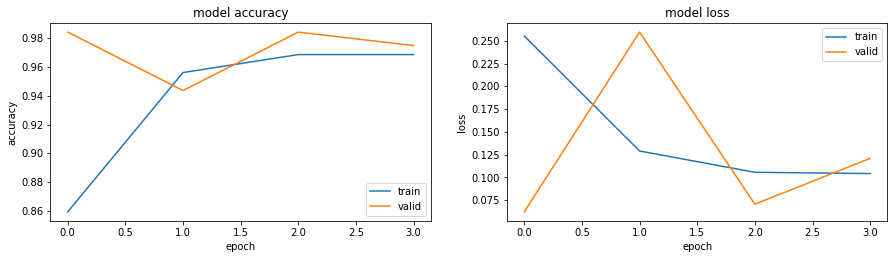

In [55]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [56]:
res_pred = model.predict_generator(res_test_data)

test_df
test_df['res_pred'] = np.argmax(res_pred, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())

test_df['res_pred'] = test_df['res_pred'].map(labels)
test_df

<ipython-input-56-59efbfd686f8>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  res_pred = model.predict_generator(res_test_data)


,filename,category,res_pred
9992,dog.6391.jpg,1,1
11053,dog.822.jpg,1,1
4514,cat.4283.jpg,0,0
3543,cat.6159.jpg,0,0
4342,dog.6173.jpg,1,0
...,...,...,...
2414,dog.2847.jpg,1,1
18924,dog.2751.jpg,1,1
23901,cat.1262.jpg,0,0
1278,cat.6043.jpg,0,0


[[477  14]
 [ 20 489]]


[Text(0, 0.5, 'cats'), Text(0, 1.5, 'dogs')]

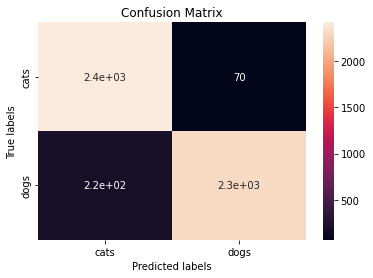

In [57]:
res_cf_matrix = confusion_matrix(test_df['category'],test_df['res_pred'])

print(res_cf_matrix)
ax= plt.subplot()
sns.heatmap(cfm, annot=True, ax = ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['cats', 'dogs'])
ax.yaxis.set_ticklabels(['cats', 'dogs'])

Using Resnet allows me to increase precision of class 0 from 0.92 to 0.96

In [58]:
print(classification_report(test_df['category'],test_df['res_pred']))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       491
           1       0.97      0.96      0.97       509

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

